# Importación de los datos

In [91]:
import spacy
import pandas as pd

df = pd.read_excel('Rest_Mex_2022_Sentiment_Analysis_Track_Train.xlsx')
# df_test = pd.read_excel('Rest_Mex_2022_Sentiment_Analysis_Track_Test.xlsx')

In [92]:
df

,Title,Opinion,Polarity,Attraction
0,Pésimo lugar,"Piensen dos veces antes de ir a este hotel, te...",1,Hotel
1,No vayas a lugar de Eddie,Cuatro de nosotros fuimos recientemente a Eddi...,1,Restaurant
2,Mala relación calidad-precio,seguiré corta y simple: limpieza\n- bad. Tengo...,1,Hotel
3,Minusválido? ¡No te alojes aquí!,Al reservar un hotel con multipropiedad Mayan ...,1,Hotel
4,Es una porqueria no pierdan su tiempo,"No pierdan su tiempo ni dinero, venimos porque...",1,Hotel
...,...,...,...,...
30207,Verdadera joya arquitectónica,"Es una construcción majestuosa, creo que de la...",5,Attractive
30208,Romántico,Muy al estilo de Romeo y Julieta es este sitio...,5,Attractive
30209,Parece un castillo,Ideal para subir las escalinatas y divisar su ...,5,Attractive
30210,Imperdible,"Es imperdible, de ahí puedes ver muy bien la c...",5,Attractive


## Normalización de los datos

In [93]:
opiniones = df['Opinion']

In [94]:
# pasar a minusculas 
opiniones = opiniones.str.lower()
# sustituir acentos por letras sin acento
opiniones = opiniones.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
# sustituir caracteres especiales
opiniones = opiniones.str.replace('[^a-z0-9\s]', '', regex=True)
# sustituir espacios en blanco por un caracter
opiniones = opiniones.str.replace('\s+', ' ', regex=True)
# Pasar a lista
opiniones = opiniones.tolist()

In [95]:
# ADJ - Adjetivo
# NOUN - Sustantivo
# VERB - Verbo
tags = ['ADJ', 'NOUN', 'VERB']

In [96]:
# eliminar stopwords 
nlp = spacy.load('es_core_news_sm')
stop_words = spacy.lang.es.stop_words.STOP_WORDS

def normalize(texto):
    # pasar a string 
    texto = str(texto)
    text = []
    doc = nlp(texto)
    for token in doc:
        # descriminar por tags
        if token.pos_ in tags:
            # descriminar por stopwords
            if token.text not in stop_words:
                # lematizar
                text.append(token.lemma_)
    text = ' '.join(text)
    return text

opiniones = [normalize(texto) for texto in opiniones]

### Nube de palabras (Extra)

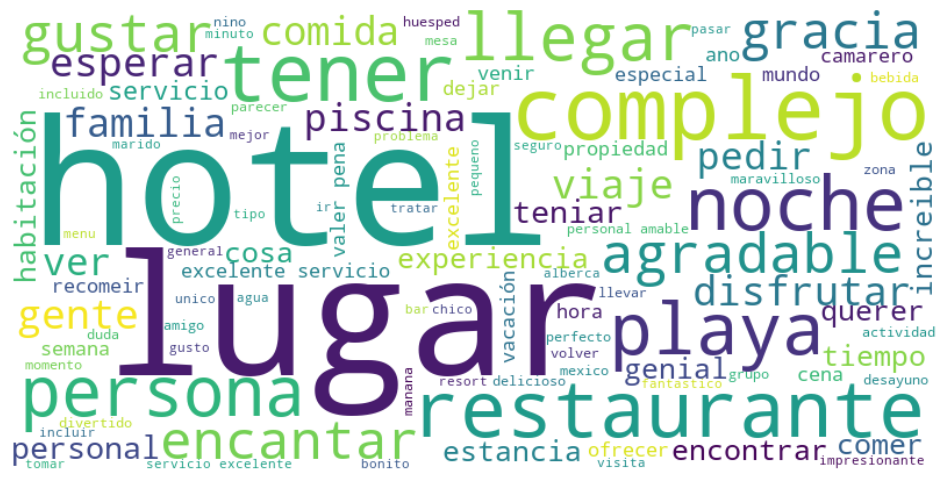

In [97]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, max_font_size=150, max_words=100, background_color='white').generate(' '.join(opiniones))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [98]:
df['Opinion'] = opiniones

## Entrenamiento del modelo

In [99]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# Tus comentarios y las etiquetas correspondientes
comentarios = df['Opinion']
etiquetas = df['Attraction']

# Preprocesar los comentarios para Doc2Vec
tagged_data = [TaggedDocument(words=comment.split(), tags=[str(i)]) for i, comment in enumerate(comentarios)]

# Entrenar el modelo Doc2Vec
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

## Clasificador KNN

### Training

In [101]:
# Crear un array con los vectores generados para cada comentario
vectors = np.array([model.infer_vector(comment.split()) for comment in comentarios])

# Dividir los datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(vectors, etiquetas, test_size=0.2, random_state=42)

# Entrenar el clasificador KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

### Testing

In [102]:
# Probar el clasificador
y_pred = knn.predict(X_test)

print("Predicciones:", y_pred)
print("Etiquetas verdaderas:", y_test)

Predicciones: ['Hotel' 'Hotel' 'Hotel' ... 'Hotel' 'Restaurant' 'Attractive']
Etiquetas verdaderas: 12440         Hotel
17279         Hotel
19737         Hotel
423           Hotel
2041     Restaurant
            ...    
1611          Hotel
8295     Attractive
18254         Hotel
17445    Restaurant
7917     Attractive
Name: Attraction, Length: 6043, dtype: object


## Matríz de confusión

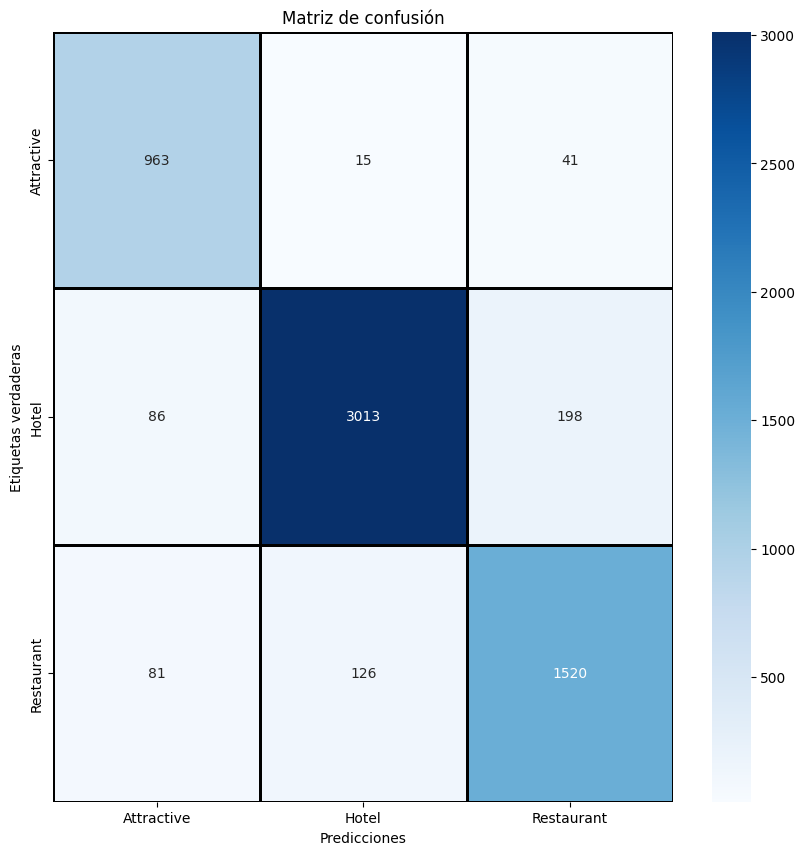

In [105]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm, cmap='Blues', linecolor='black', linewidth=1, annot=True, fmt='d')
plt.title('Matriz de confusión')
plt.ylabel('Etiquetas verdaderas')
plt.xlabel('Predicciones')
plt.show()


## Reporte de clasificación

In [106]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Attractive       0.85      0.95      0.90      1019
       Hotel       0.96      0.91      0.93      3297
  Restaurant       0.86      0.88      0.87      1727

    accuracy                           0.91      6043
   macro avg       0.89      0.91      0.90      6043
weighted avg       0.91      0.91      0.91      6043



<AxesSubplot: >

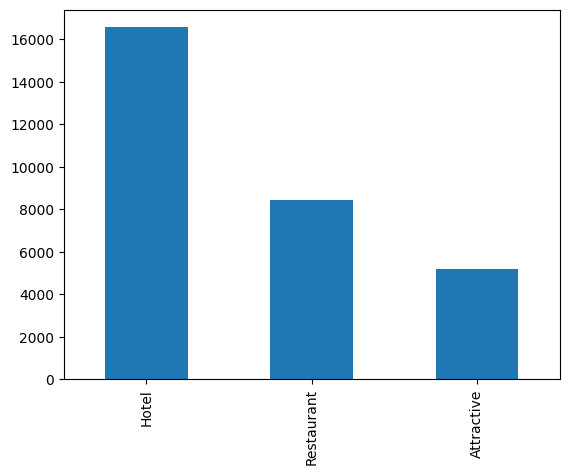

In [110]:
df['Attraction'].value_counts()

df['Attraction'].value_counts().plot(kind='bar')

Sobremuestreo (Oversampling): Aumentar el número de instancias en las clases menos representadas.

Submuestreo (Undersampling): Reducir el número de instancias en las clases más representadas.

Generación de instancias sintéticas: Utilizar técnicas como SMOTE para generar instancias sintéticas de las clases menos representadas.

Cambiar la métrica de evaluación: Utilizar métricas como la puntuación F1, en lugar de la precisión, que toman en cuenta tanto la precisión como la exhaustividad.

# Ajuste

In [ ]:
from sklearn.utils import resample

# Separar el DataFrame original en múltiples DataFrames según la categoría de atracción
dfs = [df[df['Attraction'] == category] for category in df['Attraction'].unique()]

# Encontrar el número de instancias para la clase más grande
max_instances = max(df['Attraction'].value_counts())

# Realizar sobremuestreo para cada DataFrame y almacenarlos en una lista
dfs_resampled = [resample(sub_df, replace=True, n_samples=max_instances, random_state=42) for sub_df in dfs]

# Combinar los DataFrames resampleados en un solo DataFrame
df_resampled = pd.concat(dfs_resampled, axis=0)

# Verificar la distribución de las clases después del sobremuestreo
plt.figure(figsize=(12, 6))
sns.countplot(data=df_resampled, y='Attraction', order = df_resampled['Attraction'].value_counts().index)
plt.title('Distribución de tipos de atracciones después del sobremuestreo')
plt.xlabel('Número de reseñas')
plt.ylabel('Tipo de atracción')
plt.show()


In [109]:
df_ajustado = pd.read_excel('Rest_Mex_2022_Sentiment_Analysis_Track_ajustado.xlsx')

<AxesSubplot: >

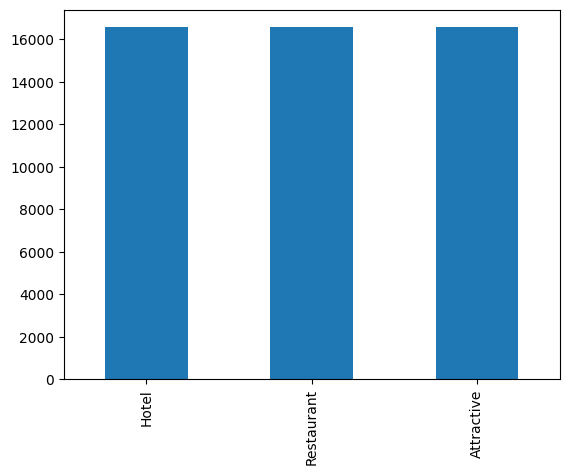

In [111]:
df_ajustado['Attraction'].value_counts()

df_ajustado['Attraction'].value_counts().plot(kind='bar')

In [112]:
opiniones_ajus = df_ajustado['Opinion']

# pasar a minusculas
opiniones_ajus = opiniones_ajus.str.lower()
# sustituir acentos por letras sin acento
opiniones_ajus = opiniones_ajus.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
# sustituir caracteres especiales
opiniones_ajus = opiniones_ajus.str.replace('[^a-z0-9\s]', '', regex=True)
# sustituir espacios en blanco por un caracter
opiniones_ajus = opiniones_ajus.str.replace('\s+', ' ', regex=True)
# Pasar a lista
opiniones_ajus = opiniones_ajus.tolist()

# eliminar stopwords
nlp = spacy.load('es_core_news_sm')
stop_words = spacy.lang.es.stop_words.STOP_WORDS

def normalize(texto):
    # pasar a string
    texto = str(texto)
    text = []
    doc = nlp(texto)
    for token in doc:
        # descriminar por tags
        if token.pos_ in tags:
            # descriminar por stopwords
            if token.text not in stop_words:
                # lematizar
                text.append(token.lemma_)
    text = ' '.join(text)
    return text

opiniones_ajus = [normalize(texto) for texto in opiniones_ajus]

df_ajustado['Opinion'] = opiniones_ajus

In [ ]:
# Tus comentarios y las etiquetas correspondientes
comentarios_ajus = df_ajustado['Opinion']
etiquetas_ajus = df_ajustado['Attraction']

# Preprocesar los comentarios para Doc2Vec
tagged_data_ajus = [TaggedDocument(words=comment.split(), tags=[str(i)]) for i, comment in enumerate(comentarios_ajus)]

# Entrenar el modelo Doc2Vec
model_ajus = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model_ajus.build_vocab(tagged_data_ajus)
model_ajus.train(tagged_data_ajus, total_examples=model_ajus.corpus_count, epochs=model_ajus.epochs)

In [114]:
# Crear un array con los vectores generados para cada comentario
vectors_ajus = np.array([model_ajus.infer_vector(comment.split()) for comment in comentarios_ajus])

# Dividir los datos para entrenamiento y prueba
X_train_ajus, X_test_ajus, y_train_ajus, y_test_ajus = train_test_split(vectors_ajus, etiquetas_ajus, test_size=0.2, random_state=42)

# Entrenar el clasificador KNN
knn_ajus = KNeighborsClassifier(n_neighbors=3)
knn_ajus.fit(X_train_ajus, y_train_ajus)

KNeighborsClassifier(n_neighbors=3)

In [115]:
# Probar el clasificador
y_pred_ajus = knn_ajus.predict(X_test_ajus)

print("Predicciones:", y_pred_ajus)
print("Etiquetas verdaderas:", y_test_ajus)

Predicciones: ['Hotel' 'Restaurant' 'Hotel' ... 'Hotel' 'Attractive' 'Restaurant']
Etiquetas verdaderas: 11902         Hotel
4162          Hotel
17736    Restaurant
48021    Attractive
38824    Attractive
            ...    
19647    Restaurant
6140          Hotel
6912          Hotel
35852    Attractive
31997    Restaurant
Name: Attraction, Length: 9939, dtype: object


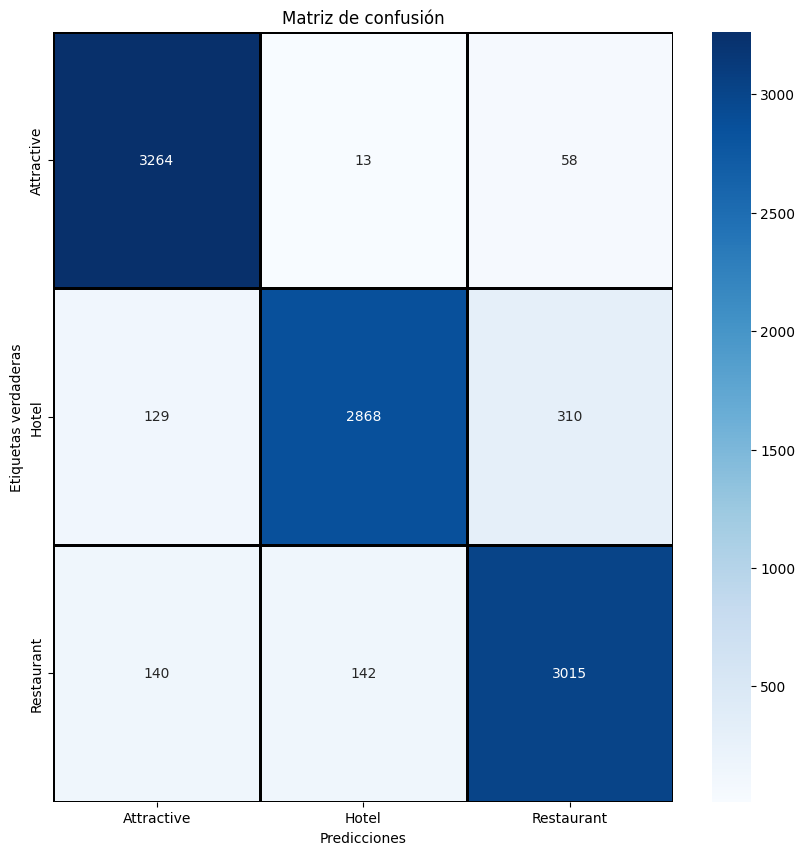

In [116]:
cm_ajus = confusion_matrix(y_test_ajus, y_pred_ajus)
cm_ajus = pd.DataFrame(cm_ajus, index=np.unique(y_test_ajus), columns=np.unique(y_test_ajus))

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm_ajus, cmap='Blues', linecolor='black', linewidth=1, annot=True, fmt='d')
plt.title('Matriz de confusión')
plt.ylabel('Etiquetas verdaderas')
plt.xlabel('Predicciones')
plt.show()

In [117]:
print(classification_report(y_test_ajus, y_pred_ajus))

              precision    recall  f1-score   support

  Attractive       0.92      0.98      0.95      3335
       Hotel       0.95      0.87      0.91      3307
  Restaurant       0.89      0.91      0.90      3297

    accuracy                           0.92      9939
   macro avg       0.92      0.92      0.92      9939
weighted avg       0.92      0.92      0.92      9939



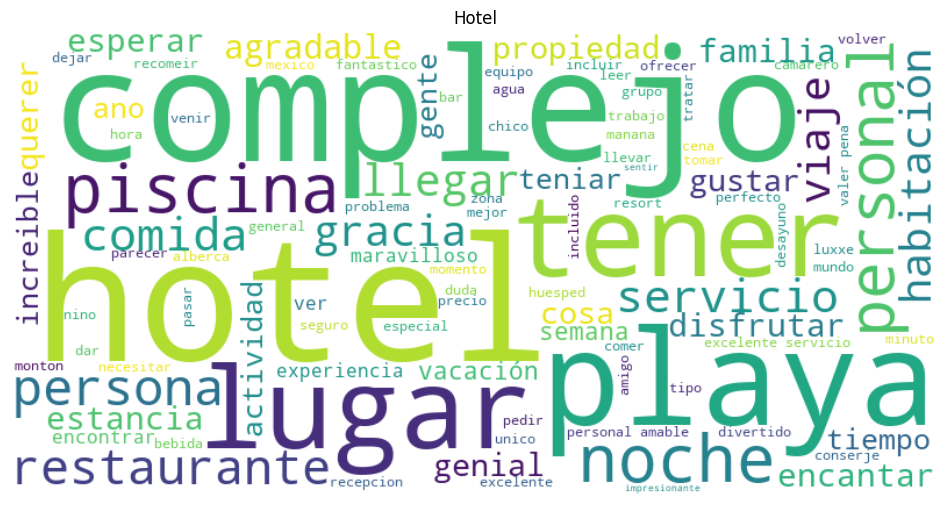

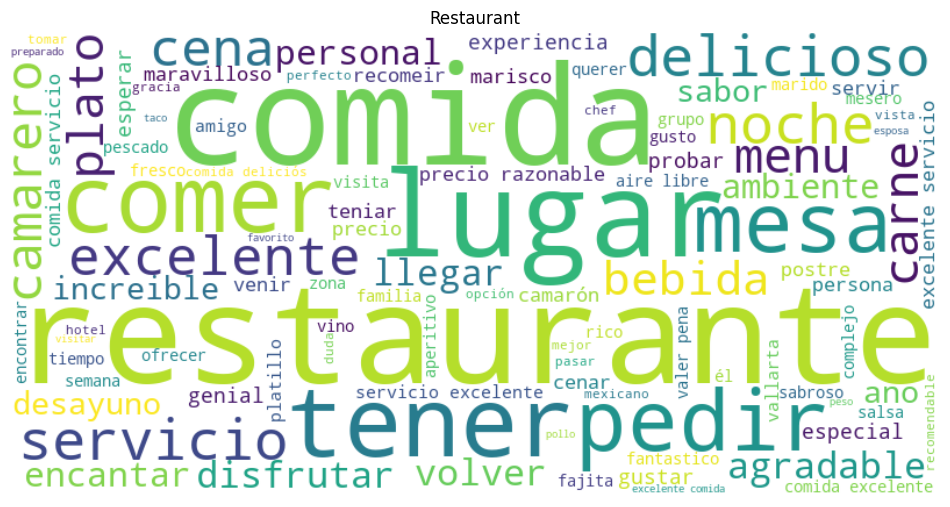

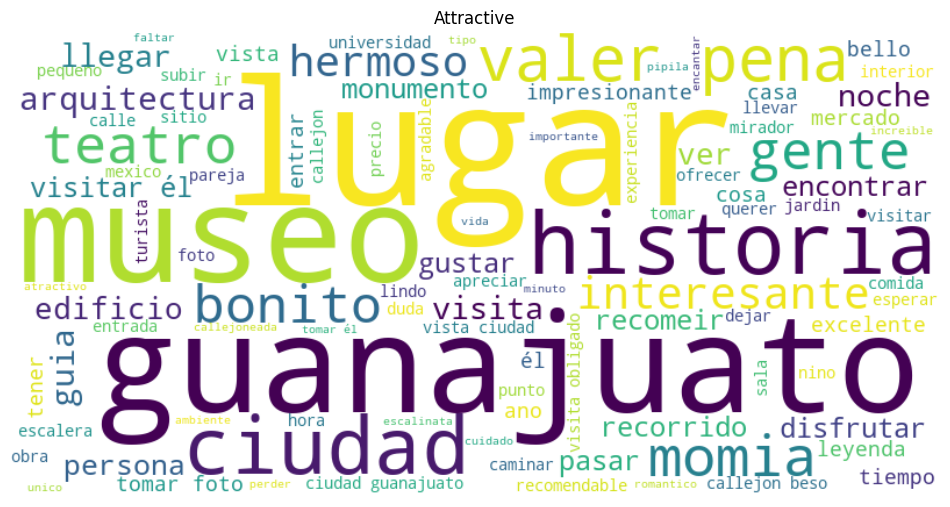

In [17]:
palabras_frec = []

# nube de palabras por cada etiqueta
for etiqueta in etiquetas.unique():
    # obtener los comentarios de la etiqueta
    comentarios = df[df['Attraction'] == etiqueta]['Opinion']
    # guardar lista de palabras de la mas frecuente y crear la nube de palabras
    wordcloud = WordCloud(width=800, height=400, max_font_size=150, max_words=100, background_color='white').generate(' '.join(comentarios))
    palabras_frec.append((etiqueta, wordcloud.words_))
    # mostrar la nube de palabras
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(etiqueta)
    plt.show()


In [19]:
#  pasar cada palabras_frec a un df
df_hotel = pd.DataFrame(palabras_frec[0][1], index=[0]).T
df_rest = pd.DataFrame(palabras_frec[1][1], index=[0]).T
df_attr = pd.DataFrame(palabras_frec[2][1], index=[0]).T

# renombrar columnas
df_hotel.columns = ['Frecuencia']
df_rest.columns = ['Frecuencia']
df_attr.columns = ['Frecuencia']

# añadir columna de etiqueta sintáctica.
df_hotel['Etiqueta'] = ''
df_rest['Etiqueta'] = ''
df_attr['Etiqueta'] = ''

In [75]:
df_hotel

,Etiqueta
hotel,NOUN
complejo,ADJ
playa,VERB
lugar,NOUN
tener,VERB
...,...
tipo,NOUN
monton,NOUN
mexico,ADJ
impresionante,ADJ


In [21]:
# para cada palabra de cada df, asignar la etiqueta sintáctica
def etiqueta_sintactica(df):
    for palabra in df.index:
        doc = nlp(palabra)
        df.loc[palabra, 'Etiqueta'] = doc[0].pos_
    return df

df_hotel = etiqueta_sintactica(df_hotel)
df_rest = etiqueta_sintactica(df_rest)
df_attr = etiqueta_sintactica(df_attr)

In [76]:
df_attr

,Etiqueta
lugar,NOUN
guanajuato,NOUN
museo,NOUN
historia,NOUN
ciudad,NOUN
...,...
faltar,VERB
tomar él,VERB
perder,VERB
atractivo,ADJ


# PRACTICA 2

['ADJ', 'NOUN', 'VERB']


In [170]:
# Agregar columnas al dataframe de ADJ_HOTEL ADJ_RESTAURANTE ADJ_ATRACCION NOUN_HOTEL NOUN_RESTAURANTE NOUN_ATRACCION VERB_HOTEL VERB_RESTAURANTE VERB_ATRACCION
df['ADJ_HOTEL'] = 0
df['NOUN_HOTEL'] = 0
df['VERB_HOTEL'] = 0
df['ADJ_RESTAURANTE'] = 0
df['NOUN_RESTAURANTE'] = 0
df['VERB_RESTAURANTE'] = 0
df['ADJ_ATRACCION'] = 0
df['NOUN_ATRACCION'] = 0
df['VERB_ATRACCION'] = 0


In [31]:
df_copy = df.copy()

In [171]:
df

,Title,Opinion,Polarity,Attraction,ADJ_HOTEL,NOUN_HOTEL,VERB_HOTEL,ADJ_RESTAURANTE,NOUN_RESTAURANTE,VERB_RESTAURANTE,ADJ_ATRACCION,NOUN_ATRACCION,VERB_ATRACCION
0,Pésimo lugar,pensar hotel molestar hijo ano traiar inflable...,1,Hotel,0,0,0,0,0,0,0,0,0
1,No vayas a lugar de Eddie,placir servicio terrible venir mesa copa vino ...,1,Restaurant,0,0,0,0,0,0,0,0,0
2,Mala relación calidad-precio,corto simple limpieza insistir limpiar suelo c...,1,Hotel,0,0,0,0,0,0,0,0,0
3,Minusválido? ¡No te alojes aquí!,reservar hotel grupo decir necesitar habitacio...,1,Hotel,0,0,0,0,0,0,0,0,0
4,Es una porqueria no pierdan su tiempo,perder tiempo dinero venir tener boda complejo...,1,Hotel,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30207,Verdadera joya arquitectónica,construccion majestuoso mitad siglo xx conserv...,5,Attractive,0,0,0,0,0,0,0,0,0
30208,Romántico,estilo romeo sitio albergar historia romantico...,5,Attractive,0,0,0,0,0,0,0,0,0
30209,Parece un castillo,ideal subir escalinata divisar linda vista pan...,5,Attractive,0,0,0,0,0,0,0,0,0
30210,Imperdible,imperdible ciudad noche funicular cosa aventur...,5,Attractive,0,0,0,0,0,0,0,0,0


In [188]:
# en df se añaden las frecuencia palabras de cada etiqueta sintáctica y se añaden a las columnas correspondientes
for i in range(len(df)):
    for palabra in df['Opinion'][i].split():
        if palabra in df_hotel.index:
            if df_hotel['Etiqueta'][palabra] == 'ADJ':
                df.loc[i, 'ADJ_HOTEL'] += 1
            elif df_hotel['Etiqueta'][palabra] == 'NOUN':
                df.loc[i, 'NOUN_HOTEL'] += 1
            elif df_hotel['Etiqueta'][palabra] == 'VERB':
                df.loc[i, 'VERB_HOTEL'] += 1
        elif palabra in df_rest.index:
            if df_rest['Etiqueta'][palabra] == 'ADJ':
                df.loc[i, 'ADJ_RESTAURANTE'] += 1
            elif df_rest['Etiqueta'][palabra] == 'NOUN':
                df.loc[i, 'NOUN_RESTAURANTE'] += 1
            elif df_rest['Etiqueta'][palabra] == 'VERB':
                df.loc[i, 'VERB_RESTAURANTE'] += 1
        elif palabra in df_attr.index:
            if df_attr['Etiqueta'][palabra] == 'ADJ':
                df.loc[i, 'ADJ_ATRACCION'] += 1
            elif df_attr['Etiqueta'][palabra] == 'NOUN':
                df.loc[i, 'NOUN_ATRACCION'] += 1
            elif df_attr['Etiqueta'][palabra] == 'VERB':
                df.loc[i, 'VERB_ATRACCION'] += 1


In [189]:
# De las columnas ADJ_RESTAURANTE	NOUN_RESTAURANTE	VERB_RESTAURANTE	ADJ_ATRACCION	NOUN_ATRACCION	VERB_ATRACCION, unelas como un vector en una nueva columna llamada 'vector'
df['vector'] = df[['ADJ_RESTAURANTE', 'NOUN_RESTAURANTE', 'VERB_RESTAURANTE', 'ADJ_ATRACCION', 'NOUN_ATRACCION', 'VERB_ATRACCION']].values.tolist()


In [190]:
# haz un clasificador con Naive Bayes 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

# Tus comentarios y las etiquetas correspondientes
comentarios = df['vector']
comentarios = np.array(comentarios.tolist())
etiquetas = df['Attraction']

# Dividir los datos para entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(comentarios, etiquetas, test_size=0.2, random_state=42)

# Entrenar el clasificador Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Probar el clasificador
y_pred = nb.predict(X_test)

print("Predicciones:", y_pred)
print("Etiquetas verdaderas:", y_test)

Predicciones: ['Hotel' 'Hotel' 'Hotel' ... 'Restaurant' 'Restaurant' 'Attractive']
Etiquetas verdaderas: 12440         Hotel
17279         Hotel
19737         Hotel
423           Hotel
2041     Restaurant
            ...    
1611          Hotel
8295     Attractive
18254         Hotel
17445    Restaurant
7917     Attractive
Name: Attraction, Length: 6043, dtype: object


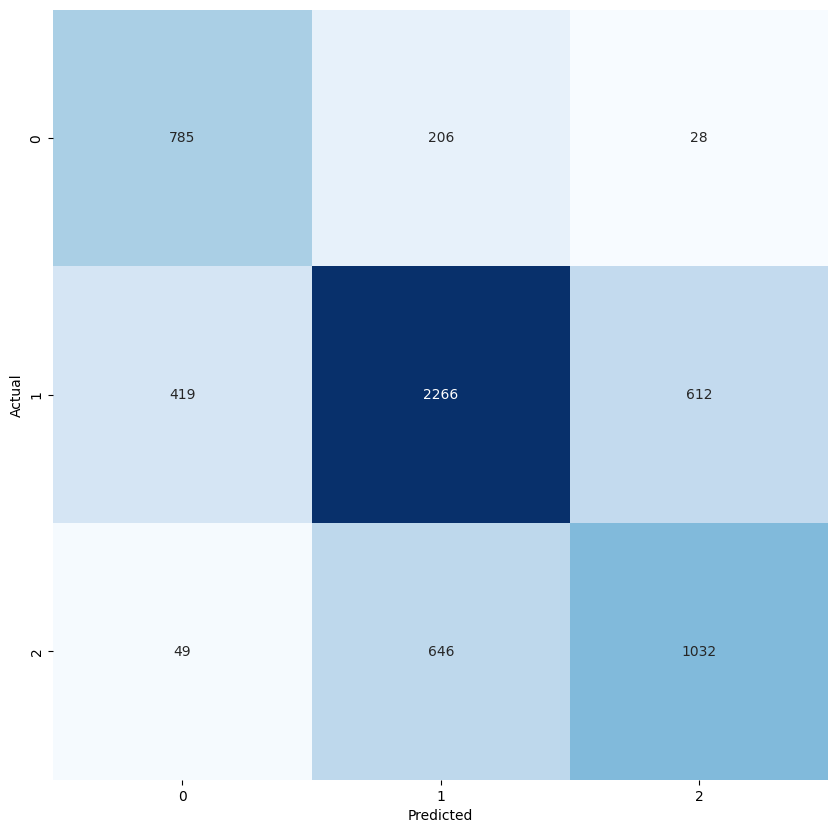

              precision    recall  f1-score   support

  Attractive       0.63      0.77      0.69      1019
       Hotel       0.73      0.69      0.71      3297
  Restaurant       0.62      0.60      0.61      1727

    accuracy                           0.68      6043
   macro avg       0.66      0.69      0.67      6043
weighted avg       0.68      0.68      0.68      6043



In [191]:
# genera la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# genera el reporte de clasificación
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

# Graficas

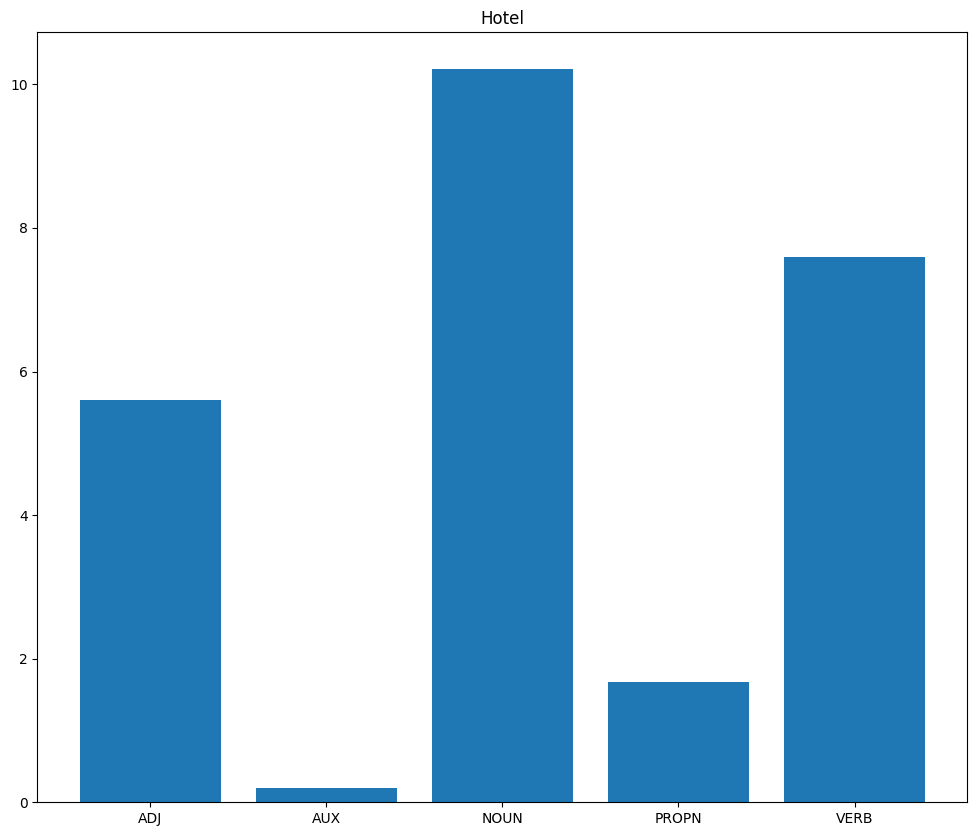

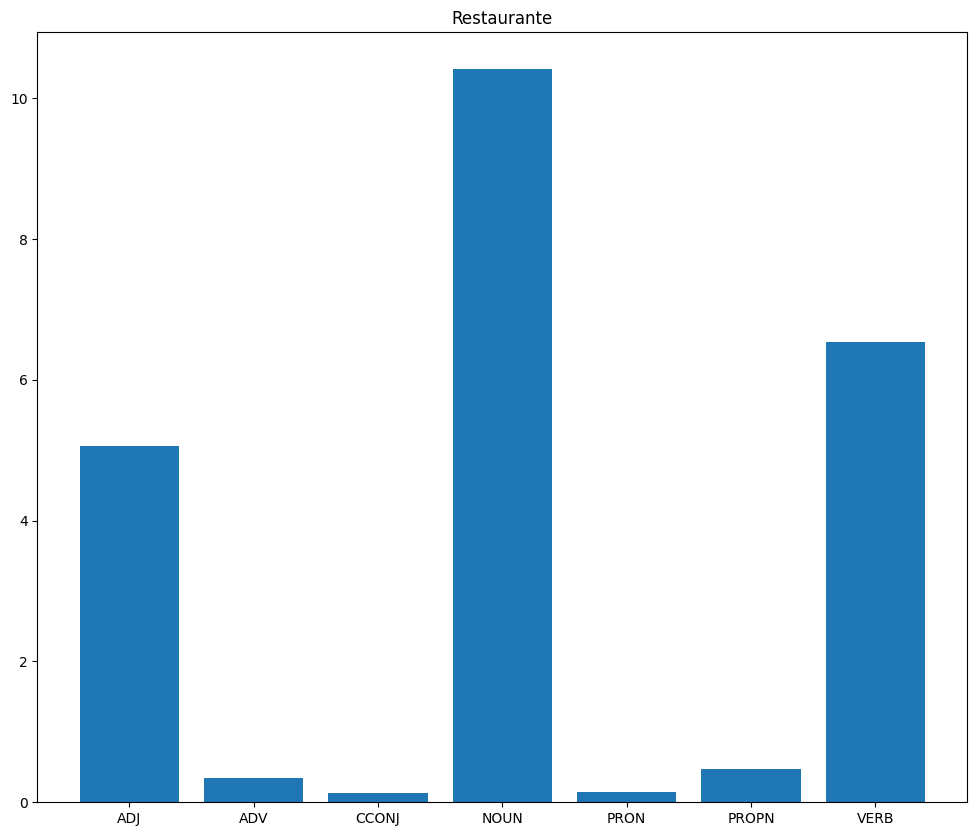

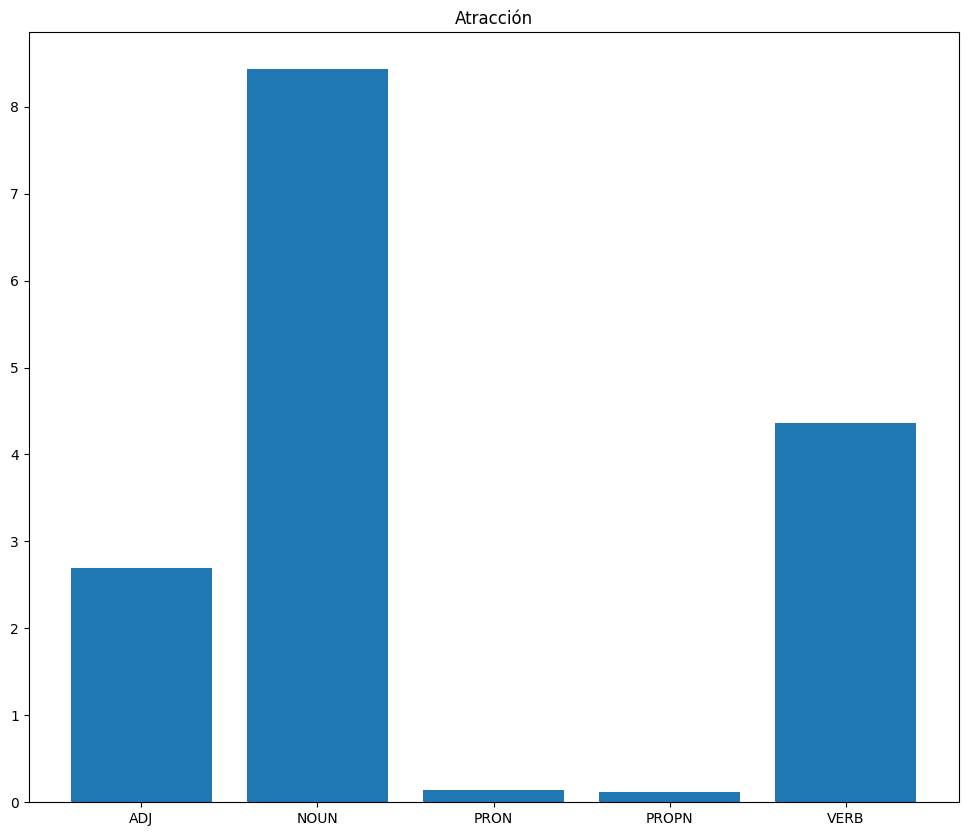

In [ ]:
# unicos de cada etiqueta y frecuencia
hotel = df_hotel.groupby('Etiqueta').sum()
rest = df_rest.groupby('Etiqueta').sum()
attr = df_attr.groupby('Etiqueta').sum()

# graficar
plt.figure(figsize=(12,10))
plt.bar(hotel.index, hotel['Frecuencia'])
plt.title('Hotel')
plt.show()

plt.figure(figsize=(12,10))
plt.bar(rest.index, rest['Frecuencia'])
plt.title('Restaurante')
plt.show()

plt.figure(figsize=(12,10))
plt.bar(attr.index, attr['Frecuencia'])
plt.title('Atracción')
plt.show()
